<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 1
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.51433206  1.308493    0.27890006  1.6382172  -0.9045951 ]
 [ 1.6951219  -0.7492928  -1.9974047  -2.2730038  -0.59148407]
 [-0.21998931  2.0157933   1.5967828  -0.70900244  2.2805166 ]
 [ 0.4295054   1.2594935  -0.11089423  0.828942   -1.2693355 ]
 [ 2.55759     0.25080293 -1.6415483   0.6614332   0.26615044]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


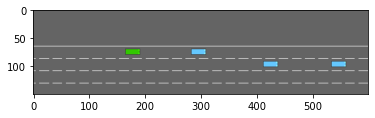

[[ 1.          0.8891334   0.          0.3125      0.        ]
 [ 1.          0.10697213  0.         -0.02723078  0.        ]
 [ 1.          0.22416282  0.25       -0.01700746  0.        ]
 [ 1.          0.33537617  0.25       -0.01635072  0.        ]
 [ 1.          0.44271946  0.         -0.02025815  0.        ]]

Acción: LANE_LEFT -> recommpensa: 0.7999999999999999
Nuevo estado:


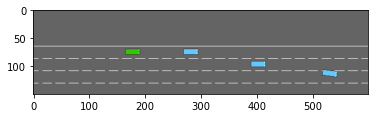

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.09368397  0.         -0.03887621  0.        ]
 [ 1.          0.20364562  0.25       -0.08415785  0.        ]
 [ 1.          0.32179192  0.44557074 -0.03922848  0.03706711]
 [ 1.          0.43266466  0.         -0.02984062  0.        ]]

Acción: SLOWER -> recommpensa: 0.6894517646168187
Nuevo estado:


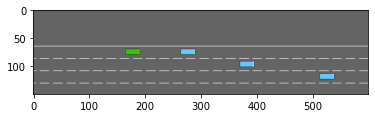

[[ 1.          1.          0.          0.26068053  0.        ]
 [ 1.          0.0893342   0.          0.00627732  0.        ]
 [ 1.          0.18548751  0.25       -0.01758902  0.        ]
 [ 1.          0.31593412  0.51116294 -0.00396843  0.00147645]
 [ 1.          0.4320542   0.          0.01570931  0.        ]]

Acción: IDLE -> recommpensa: 0.6705603718311518
Nuevo estado:


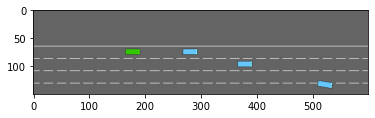

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5182518e-01
   0.0000000e+00]
 [ 1.0000000e+00  9.3185894e-02  0.0000000e+00  1.1161210e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.8255457e-01  2.5000000e-01  9.6560462e-04
   0.0000000e+00]
 [ 1.0000000e+00  3.1338435e-01  6.7701608e-01 -4.4274195e-03
   4.0774796e-02]
 [ 1.0000000e+00  4.3953145e-01  0.0000000e+00  1.9575438e-02
   0.0000000e+00]]

Acción: LANE_RIGHT -> recommpensa: 0.6895542772906024
Nuevo estado:


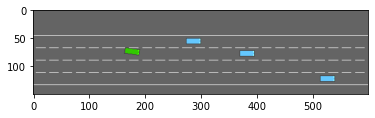

[[ 1.          1.          0.20852911  0.24811305  0.03310528]
 [ 1.          0.09895573 -0.20852911  0.01236801 -0.03310528]
 [ 1.          0.18596737  0.04147089  0.01066323 -0.03310528]
 [ 1.          0.3163692   0.5524391   0.01206549 -0.02943897]
 [ 1.          0.44829464 -0.20852911  0.01860294 -0.03310528]]

Acción: SLOWER -> recommpensa: 0.6890025959381983
Nuevo estado:


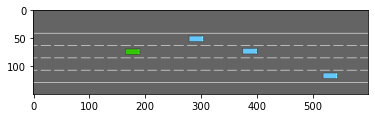

[[ 1.0000000e+00  1.0000000e+00  2.6120552e-01  2.5005248e-01
   6.3974957e-04]
 [ 1.0000000e+00  1.0289010e-01 -2.6120552e-01  8.6775552e-03
  -6.3974957e-04]
 [ 1.0000000e+00  1.9027999e-01 -1.1205522e-02  1.2208082e-02
  -6.3974957e-04]
 [ 1.0000000e+00  3.2163095e-01  4.9270642e-01  1.5456807e-02
  -2.6807282e-03]
 [ 1.0000000e+00  4.5417061e-01 -2.6120552e-01  1.1809528e-02
  -6.3974957e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.7111305423080322
Nuevo estado:


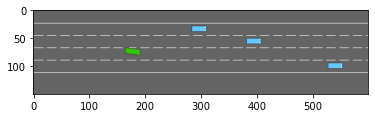

[[ 1.          1.          0.46082819  0.24801068  0.03154773]
 [ 1.          0.10742272 -0.46082819  0.00929029 -0.03154773]
 [ 1.          0.19691911 -0.2108282   0.01642887 -0.03154773]
 [ 1.          0.32973677  0.28866136  0.02031464 -0.03175699]
 [ 1.          0.45926696 -0.46082819  0.00862168 -0.03154773]]

Acción: LANE_RIGHT -> recommpensa: 0.7333366538962719
Nuevo estado:


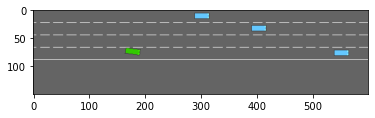

[[ 1.          1.          0.7191606   0.24770768  0.03378879]
 [ 1.          0.11233944 -0.7191606   0.00822415 -0.03378879]
 [ 1.          0.20516555 -0.4691606   0.01764224 -0.03378879]
 [ 1.          0.33960786  0.03063336  0.02196898 -0.03368741]
 [ 1.          0.4631597  -0.7191606   0.00393535 -0.03378879]]

Acción: FASTER -> recommpensa: 0.8438821361616533
Nuevo estado:


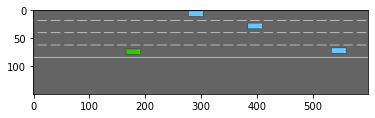

[[ 1.          1.          0.766976    0.30181637 -0.00143022]
 [ 1.          0.1020446  -0.766976   -0.04710313  0.00143022]
 [ 1.          0.19888185 -0.516976   -0.03653184  0.00143022]
 [ 1.          0.33516225 -0.01695261 -0.031637    0.00144208]
 [ 1.          0.4509414  -0.766976   -0.05210365  0.00143022]]

Acción: LANE_RIGHT -> recommpensa: 0.8627730584718795
Nuevo estado:


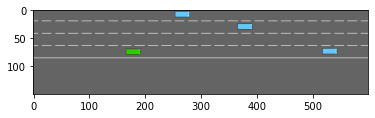

[[ 1.          1.          0.7519296   0.31066793 -0.00207623]
 [ 1.          0.08088254 -0.7519296  -0.05685072  0.00207623]
 [ 1.          0.18205273 -0.5019296  -0.04581444  0.00207623]
 [ 1.          0.3203823  -0.00191884 -0.04045824  0.00207124]
 [ 1.          0.4278969  -0.7519296  -0.06107111  0.00207623]]

Acción: LANE_RIGHT -> recommpensa: 0.8660012948359336
Nuevo estado:


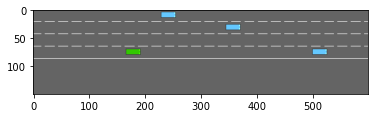

[[ 1.0000000e+00  1.0000000e+00  7.4904811e-01  3.1218809e-01
   9.3402057e-05]
 [ 1.0000000e+00  5.7656512e-02 -7.4904811e-01 -5.8942281e-02
  -9.3402057e-05]
 [ 1.0000000e+00  1.6326088e-01 -4.9904808e-01 -4.7856044e-02
  -9.3402057e-05]
 [ 1.0000000e+00  3.0379376e-01  9.5085800e-04 -4.2203698e-02
  -9.4066701e-05]
 [ 1.0000000e+00  4.0320739e-01 -7.4904811e-01 -6.1937496e-02
  -9.3402057e-05]]

Acción: LANE_RIGHT -> recommpensa: 0.8665529624491427
Nuevo estado:


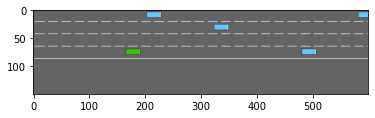

[[ 1.0000000e+00  1.0000000e+00  7.4989611e-01  3.1244668e-01
   1.1404491e-04]
 [ 1.0000000e+00  3.3951189e-02 -7.4989611e-01 -5.9514306e-02
  -1.1404491e-04]
 [ 1.0000000e+00  1.4396055e-01 -4.9989614e-01 -4.8617315e-02
  -1.1404491e-04]
 [ 1.0000000e+00  2.8678566e-01  1.0331029e-04 -4.2821135e-02
  -1.1380037e-04]
 [ 1.0000000e+00  3.7852880e-01 -7.4989611e-01 -6.1338790e-02
  -1.1404491e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.8666472359536646
Nuevo estado:


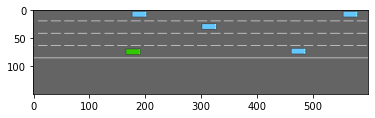

[[ 1.0000000e+00  1.0000000e+00  7.5005251e-01  3.1249088e-01
  -5.4336278e-06]
 [ 1.0000000e+00  1.0104887e-02 -7.5005251e-01 -5.9693318e-02
   5.4336278e-06]
 [ 1.0000000e+00  1.2441619e-01 -5.0005251e-01 -4.9117748e-02
   5.4336278e-06]
 [ 1.0000000e+00  2.6956868e-01 -5.2494437e-05 -4.3289728e-02
   5.4704751e-06]
 [ 1.0000000e+00  3.5413516e-01 -7.5005251e-01 -6.0589477e-02
   5.4336278e-06]]

Acción: SLOWER -> recommpensa: 0.7561151108032428
Nuevo estado:


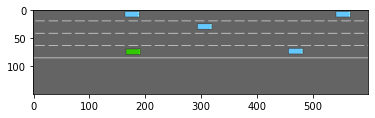

[[ 1.00000000e+00  1.00000000e+00  7.50007093e-01  2.60678947e-01
  -6.13578095e-06]
 [ 1.00000000e+00 -1.21819414e-03 -7.50007093e-01 -7.90559500e-03
   6.13578095e-06]
 [ 1.00000000e+00  1.17251955e-01 -5.00007093e-01  2.27906019e-03
   6.13578095e-06]
 [ 1.00000000e+00  2.64730364e-01 -7.07624349e-06  8.06991290e-03
   6.12391977e-06]
 [ 1.00000000e+00  3.42584729e-01 -7.50007093e-01 -8.14546738e-03
   6.13578095e-06]]

Acción: SLOWER -> recommpensa: 0.7372264710668118
Nuevo estado:


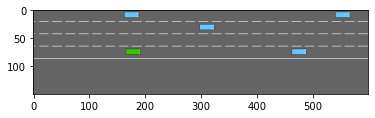

[[ 1.00000000e+00  1.00000000e+00  7.49997854e-01  2.51824915e-01
  -3.17141620e-08]
 [ 1.00000000e+00 -2.22840346e-03 -7.49997854e-01  9.84798651e-04
   3.17141620e-08]
 [ 1.00000000e+00  1.20237112e-01 -4.99997854e-01  1.07452655e-02
   3.17141620e-08]
 [ 1.00000000e+00  2.70019174e-01  2.13615044e-06  1.64644420e-02
   2.96927709e-08]
 [ 1.00000000e+00  3.41564119e-01 -7.49997854e-01  1.16617035e-03
   3.17141620e-08]]

Acción: SLOWER -> recommpensa: 0.7339986247677639
Nuevo estado:


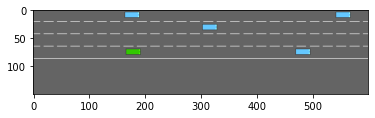

[[ 1.00000000e+00  1.00000000e+00  7.49999642e-01  2.50311852e-01
   2.89642827e-07]
 [ 1.00000000e+00 -1.45626499e-03 -7.49999642e-01  2.56158435e-03
  -2.89642827e-07]
 [ 1.00000000e+00  1.24832146e-01 -4.99999613e-01  1.18857557e-02
  -2.89642827e-07]
 [ 1.00000000e+00  2.76886523e-01  3.79112606e-07  1.75219923e-02
  -2.89072716e-07]
 [ 1.00000000e+00  3.42458934e-01 -7.49999642e-01  2.98455986e-03
  -2.89642827e-07]]

Acción: LANE_LEFT -> recommpensa: 0.7112248015898528
Nuevo estado:


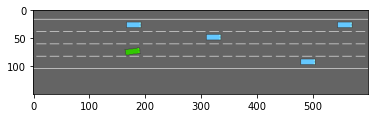

[[ 1.          1.          0.5413001   0.24785244 -0.03310314]
 [ 1.          0.00109154 -0.5413001   0.00509198  0.03310314]
 [ 1.          0.13102813 -0.29130012  0.01398054  0.03310314]
 [ 1.          0.28532168  0.2086999   0.01953593  0.03310314]
 [ 1.          0.34520072 -0.5413001   0.00562927  0.03310314]]

Acción: IDLE -> recommpensa: 0.7111305394763171
Nuevo estado:


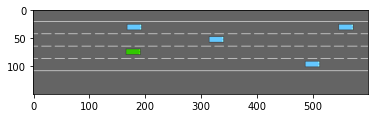

[[ 1.00000000e+00  1.00000000e+00  4.88761812e-01  2.50008345e-01
  -6.18730730e-04]
 [ 1.00000000e+00  2.41856906e-03 -4.88761812e-01  3.00314138e-03
   6.18730730e-04]
 [ 1.00000000e+00  1.35830507e-01 -2.38761812e-01  1.14648575e-02
   6.18730730e-04]
 [ 1.00000000e+00  2.92332351e-01  2.61238188e-01  1.69476364e-02
   6.18730730e-04]
 [ 1.00000000e+00  3.46750349e-01 -4.88761812e-01  3.56953382e-03
   6.18730730e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.7333366534123651
Nuevo estado:


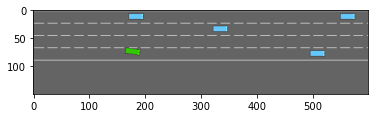

[[ 1.          1.          0.7066582   0.24758795  0.03465525]
 [ 1.          0.00521258 -0.7066582   0.00548128 -0.03465525]
 [ 1.          0.14193162 -0.45665815  0.01353021 -0.03465525]
 [ 1.          0.30061454  0.04334183  0.01895018 -0.03465525]
 [ 1.          0.34976766 -0.7066582   0.00602271 -0.03465525]]

Acción: LANE_LEFT -> recommpensa: 0.7111116784735557
Nuevo estado:


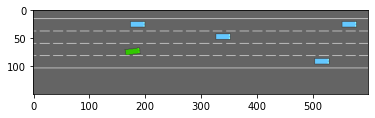

[[ 1.          1.          0.5525975   0.24790075 -0.03233185]
 [ 1.          0.00732309 -0.5525975   0.00521488  0.03233185]
 [ 1.          0.14718731 -0.30259752  0.01286863  0.03233185]
 [ 1.          0.30802786  0.19740248  0.0182346   0.03233185]
 [ 1.          0.35208485 -0.5525975   0.00569923  0.03233185]]

Acción: LANE_LEFT -> recommpensa: 0.6888889858444555
Nuevo estado:


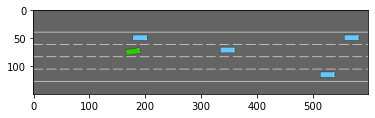

[[ 1.          1.          0.2825529   0.247475   -0.03544213]
 [ 1.          0.01104075 -0.2825529   0.0056756   0.03544213]
 [ 1.          0.15389574 -0.03255289  0.01295411  0.03544213]
 [ 1.          0.31687364  0.4674471   0.01827263  0.03544213]
 [ 1.          0.35598278 -0.2825529   0.00608574  0.03544213]]

Acción: LANE_LEFT -> recommpensa: 0.0
Nuevo estado:


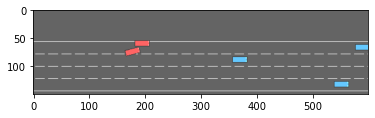

[[ 1.          1.          0.09040332  0.13022183 -0.03309034]
 [ 1.          0.01474546 -0.16155626  0.00583764  0.03309034]
 [ 1.          0.1743645   0.15959668  0.12987782  0.03309034]
 [ 1.          0.33946162  0.6595967   0.13515283  0.03309034]
 [ 1.          0.3737559  -0.09040332  0.12328195  0.03309034]]
Episodio terminado después de 21 pasos y la recompensa fue 15.071925759187712


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de mejorado

In [3]:
env = gym.make('highway-v0')
env.configure({
    "observation": {
        "type": "OccupancyGrid"
    }
})
_ = env.reset()

In [4]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

In [5]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (self.n_inputs,)))  # acción del cálculo de Q para esta acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

In [6]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_position = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.update_position.append(self.state0[0]) # Guardamos la posición final de cada episodio
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

In [9]:
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 64      # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 100       # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [10]:
# Carga de la red neuronal
dqn_occupancy = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn_occupancy = DQNAgent(
    env=env,
    main_network=dqn_occupancy,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn_occupancy.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-6-7b9067ae957f>:137: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 12 Mean Rewards 8.47 Epsilon 0.8953382542587163		

C:\Users\mario\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mario\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 1500 Mean Rewards 30.14 Epsilon 0.01		118606165716			
Episode limit reached


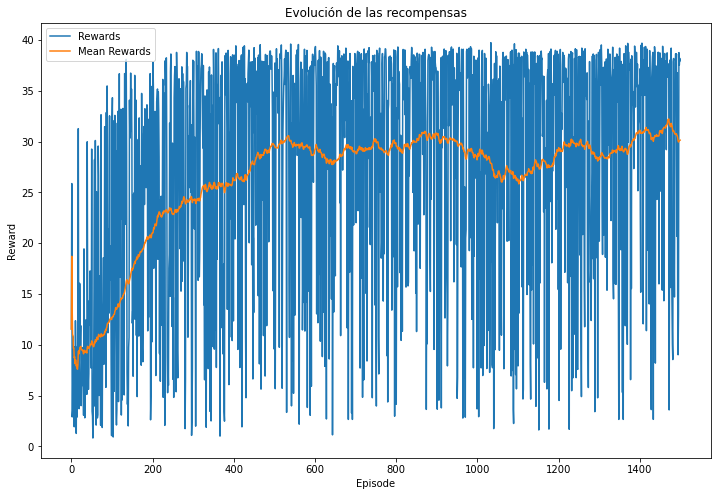

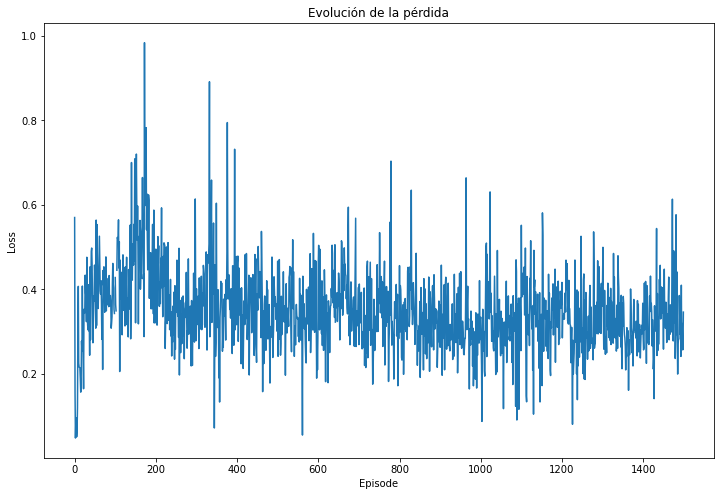

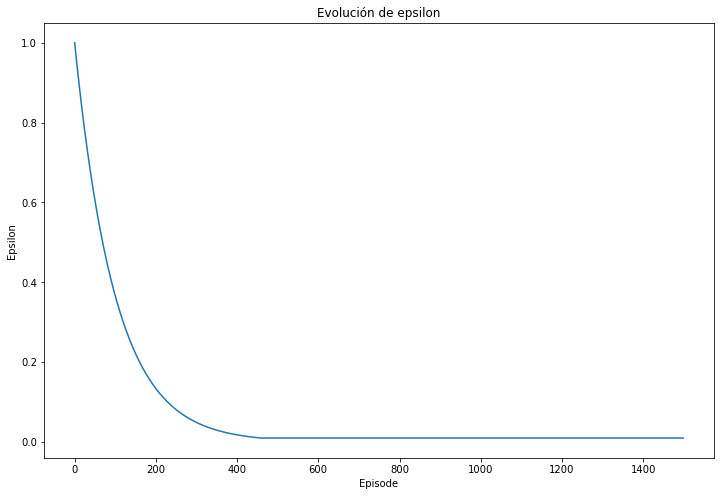

In [11]:
agent_dqn_occupancy.plot_rewards()
agent_dqn_occupancy.plot_loss()
agent_dqn_occupancy.plot_epsilon()

In [12]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn_occupancy.main_network.state_dict()
}
torch.save(trained_model, "DQN_occupancy.pth")

Obs inicial:


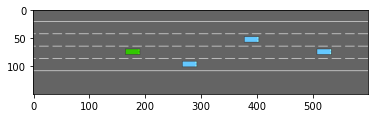


Acción: FASTER -> recommpensa: 0.9549926798276257
Nuevo estado:


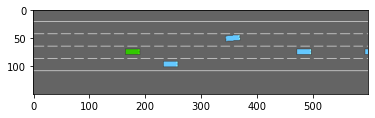


Acción: FASTER -> recommpensa: 0.9738840726132926
Nuevo estado:


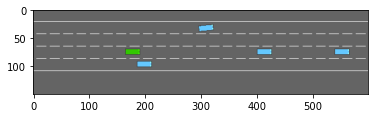


Acción: FASTER -> recommpensa: 0.9771123893760643
Nuevo estado:


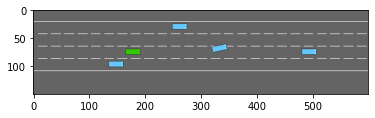


Acción: FASTER -> recommpensa: 0.9776640707284683
Nuevo estado:


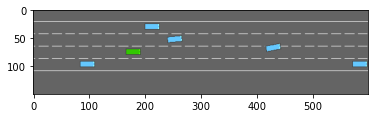


Acción: FASTER -> recommpensa: 0.9777583465808567
Nuevo estado:


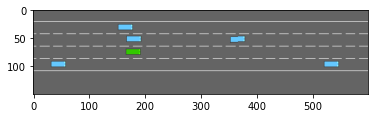


Acción: FASTER -> recommpensa: 0.9777744572148391
Nuevo estado:


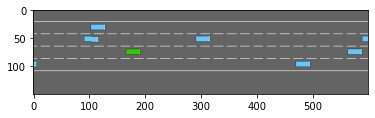


Acción: FASTER -> recommpensa: 0.9777772103326393
Nuevo estado:


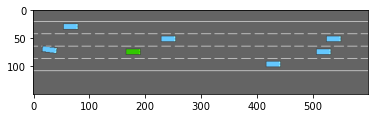


Acción: IDLE -> recommpensa: 0.9777776808080798
Nuevo estado:


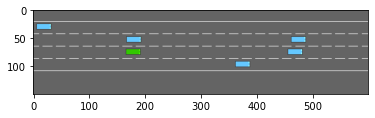


Acción: FASTER -> recommpensa: 0.9777777612067973
Nuevo estado:


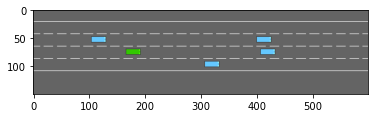


Acción: FASTER -> recommpensa: 0.977777774945992
Nuevo estado:


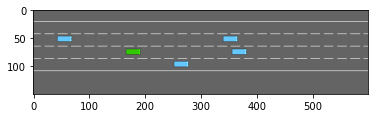


Acción: FASTER -> recommpensa: 0.9777777772938588
Nuevo estado:


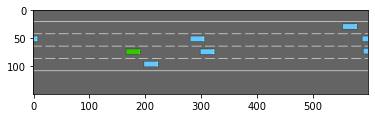


Acción: FASTER -> recommpensa: 0.9777777776950818
Nuevo estado:


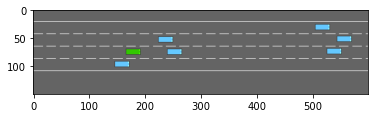


Acción: LANE_RIGHT -> recommpensa: 0.9999999999858683
Nuevo estado:


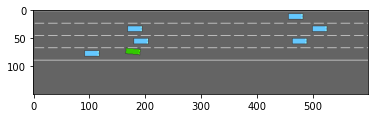


Acción: FASTER -> recommpensa: 0.9999999999975852
Nuevo estado:


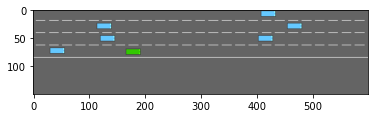


Acción: FASTER -> recommpensa: 0.9999999999995873
Nuevo estado:


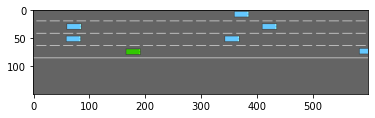


Acción: LANE_RIGHT -> recommpensa: 0.9999999999999295
Nuevo estado:


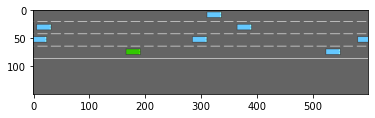


Acción: FASTER -> recommpensa: 0.999999999999988
Nuevo estado:


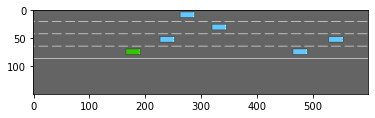


Acción: LANE_RIGHT -> recommpensa: 0.9999999999999979
Nuevo estado:


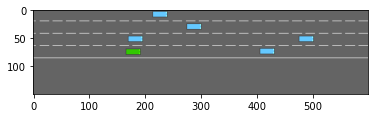


Acción: FASTER -> recommpensa: 0.9999999999999997
Nuevo estado:


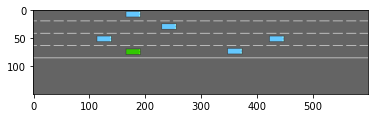


Acción: LANE_LEFT -> recommpensa: 0.9777777777777774
Nuevo estado:


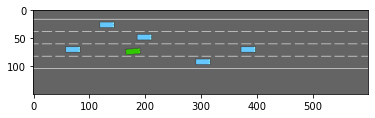


Acción: FASTER -> recommpensa: 0.9777777777777774
Nuevo estado:


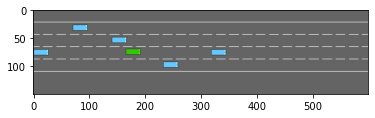


Acción: FASTER -> recommpensa: 0.9777777777777774
Nuevo estado:


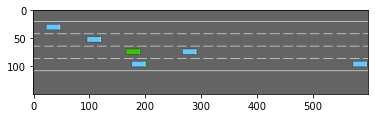


Acción: SLOWER -> recommpensa: 0.8672295423945964
Nuevo estado:


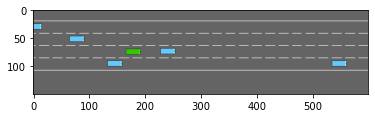


Acción: LANE_LEFT -> recommpensa: 0.8261159273867072
Nuevo estado:


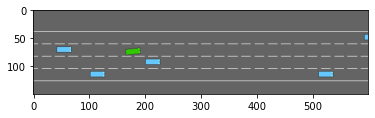


Acción: FASTER -> recommpensa: 0.933435846007117
Nuevo estado:


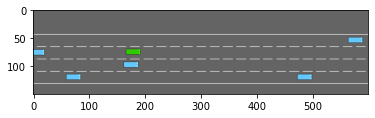


Acción: FASTER -> recommpensa: 0.9517755574403798
Nuevo estado:


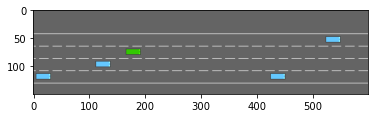


Acción: LANE_RIGHT -> recommpensa: 0.9771318205729852
Nuevo estado:


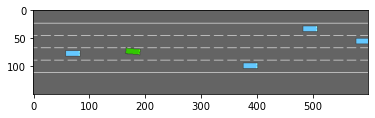


Acción: FASTER -> recommpensa: 0.9776673912914067
Nuevo estado:


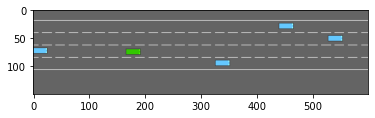


Acción: FASTER -> recommpensa: 0.9777589140259951
Nuevo estado:


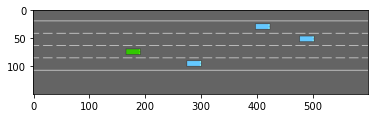


Acción: LANE_LEFT -> recommpensa: 0.955552331962315
Nuevo estado:


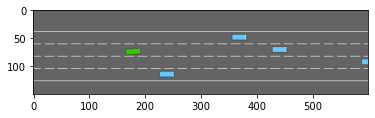


Acción: FASTER -> recommpensa: 0.9555550046813975
Nuevo estado:


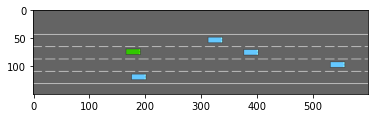


Acción: FASTER -> recommpensa: 0.9555554614176431
Nuevo estado:


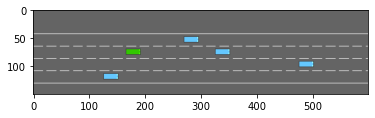


Acción: FASTER -> recommpensa: 0.9555555394684939
Nuevo estado:


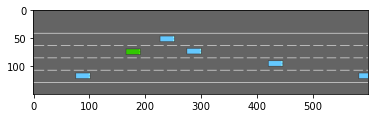


Acción: LANE_RIGHT -> recommpensa: 0.9777777750286883
Nuevo estado:


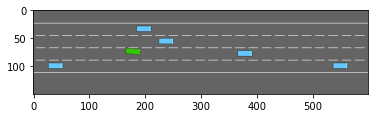


Acción: FASTER -> recommpensa: 0.9777777773079909
Nuevo estado:


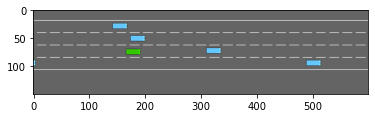


Acción: IDLE -> recommpensa: 0.9777777776974967
Nuevo estado:


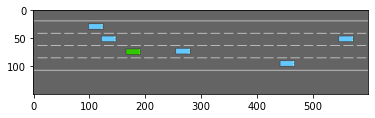


Acción: LANE_LEFT -> recommpensa: 0.9555555555418365
Nuevo estado:


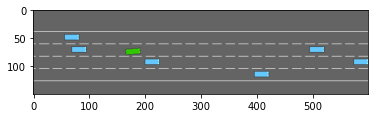


Acción: FASTER -> recommpensa: 0.9555555555532113
Nuevo estado:


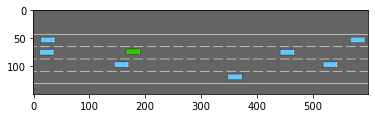


Acción: FASTER -> recommpensa: 0.955555555555155
Nuevo estado:


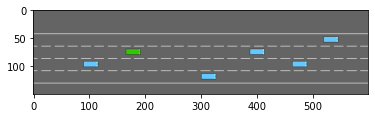


Acción: FASTER -> recommpensa: 0.9555555555554872
Nuevo estado:


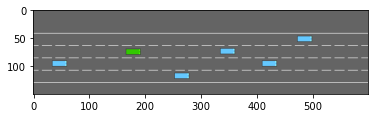

Episodio terminado después de 40 pasos y la recompensa fue 38.728074220828795


In [15]:
# Carga del modelo entrenado
modelo = torch.load("DQN_occupancy.pth")['state_dic']
dqn_occupancy.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
# print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn_occupancy.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
#     print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))